In [1]:
import os
import cv2
import pafy
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt

from moviepy.editor import *
%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

In [2]:
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

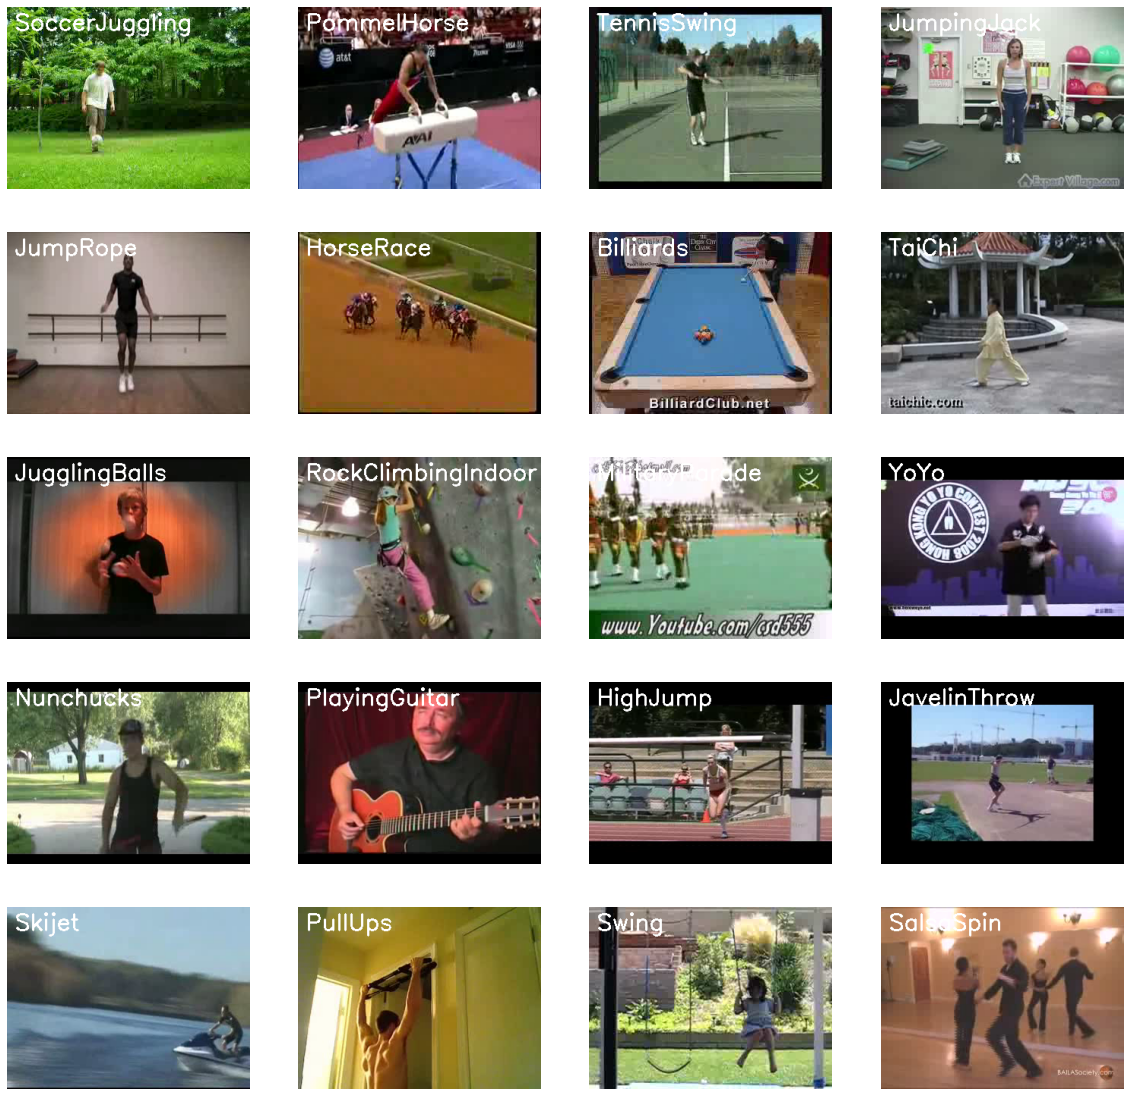

In [3]:
plt.figure(figsize = (20, 20))

all_classes_names = os.listdir('C:\dataset for major project/UCF50')

random_range = random.sample(range(len(all_classes_names)), 20)

for counter, random_index in enumerate(random_range, 1):

  selected_class_Name = all_classes_names[random_index]

  video_files_names_list = os.listdir(f'C:\dataset for major project/UCF50/{selected_class_Name}')

  selected_video_file_name = random.choice(video_files_names_list)

  video_reader = cv2.VideoCapture(f'C:\dataset for major project/UCF50/{selected_class_Name}/{selected_video_file_name}')

  _, bgr_frame = video_reader.read()

  video_reader.release()

  rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

  cv2.putText(rgb_frame, selected_class_Name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

  plt.subplot(5, 4, counter);plt.imshow(rgb_frame);plt.axis('off')

In [4]:

IMAGE_HEIGHT , IMAGE_WIDTH = 64, 64


SEQUENCE_LENGTH = 20

 
DATASET_DIR = "C:\dataset for major project/UCF50"


CLASSES_LIST = ["WalkingWithDog", "TaiChi", "Swing", "HorseRace","PushUps","Diving","Punch","Biking","Basketball","PlayingGuitar"]

In [6]:
def frames_extraction(video_path):
    
    frames_list = []
    
    video_reader = cv2.VideoCapture(video_path)

    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

    for frame_counter in range(SEQUENCE_LENGTH):

       
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        success, frame = video_reader.read() 

        if not success:
            break

        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        
        normalized_frame = resized_frame / 255
        
        frames_list.append(normalized_frame)
    
    video_reader.release()

    return frames_list

In [7]:
def create_dataset():

    features = []
    labels = []
    video_files_paths = []
    
    for class_index, class_name in enumerate(CLASSES_LIST):
        
        print(f'Extracting Data of Class: {class_name}')
        
       
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))
        
        for file_name in files_list:
            
            
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)

            
            frames = frames_extraction(video_file_path)

            
            if len(frames) == SEQUENCE_LENGTH:

                
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)

   
    features = np.asarray(features)
    labels = np.array(labels)  
    

    return features, labels, video_files_paths

In [ ]:
# Create the dataset.
features, labels, video_files_paths = create_dataset()

Extracting Data of Class: WalkingWithDog
Extracting Data of Class: TaiChi


In [20]:
one_hot_encoded_labels = to_categorical(labels)

In [21]:
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels,
                                                                            test_size = 0.25, shuffle = True,
                                                                            random_state = seed_constant)

In [56]:
def create_convlstm_model():
    

   
    model = Sequential()

    
    
    model.add(ConvLSTM2D(filters = 4, kernel_size = (3, 3), activation = 'tanh',data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True, input_shape = (SEQUENCE_LENGTH,
                                                                                      IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM2D(filters = 8, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM2D(filters = 14, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM2D(filters = 16, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    
    
    model.add(Flatten()) 
    
    model.add(Dense(len(CLASSES_LIST), activation = "softmax"))
    
    
    model.summary()
    
    
    return model

In [57]:
convlstm_model = create_convlstm_model()

print("Model Created Successfully!")

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_4 (ConvLSTM2D)  (None, 20, 62, 62, 4)     1024      
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, 20, 31, 31, 4)     0         
_________________________________________________________________
time_distributed_27 (TimeDis (None, 20, 31, 31, 4)     0         
_________________________________________________________________
conv_lst_m2d_5 (ConvLSTM2D)  (None, 20, 29, 29, 8)     3488      
_________________________________________________________________
max_pooling3d_5 (MaxPooling3 (None, 20, 15, 15, 8)     0         
_________________________________________________________________
time_distributed_28 (TimeDis (None, 20, 15, 15, 8)     0         
_________________________________________________________________
conv_lst_m2d_6 (ConvLSTM2D)  (None, 20, 13, 13, 14)   

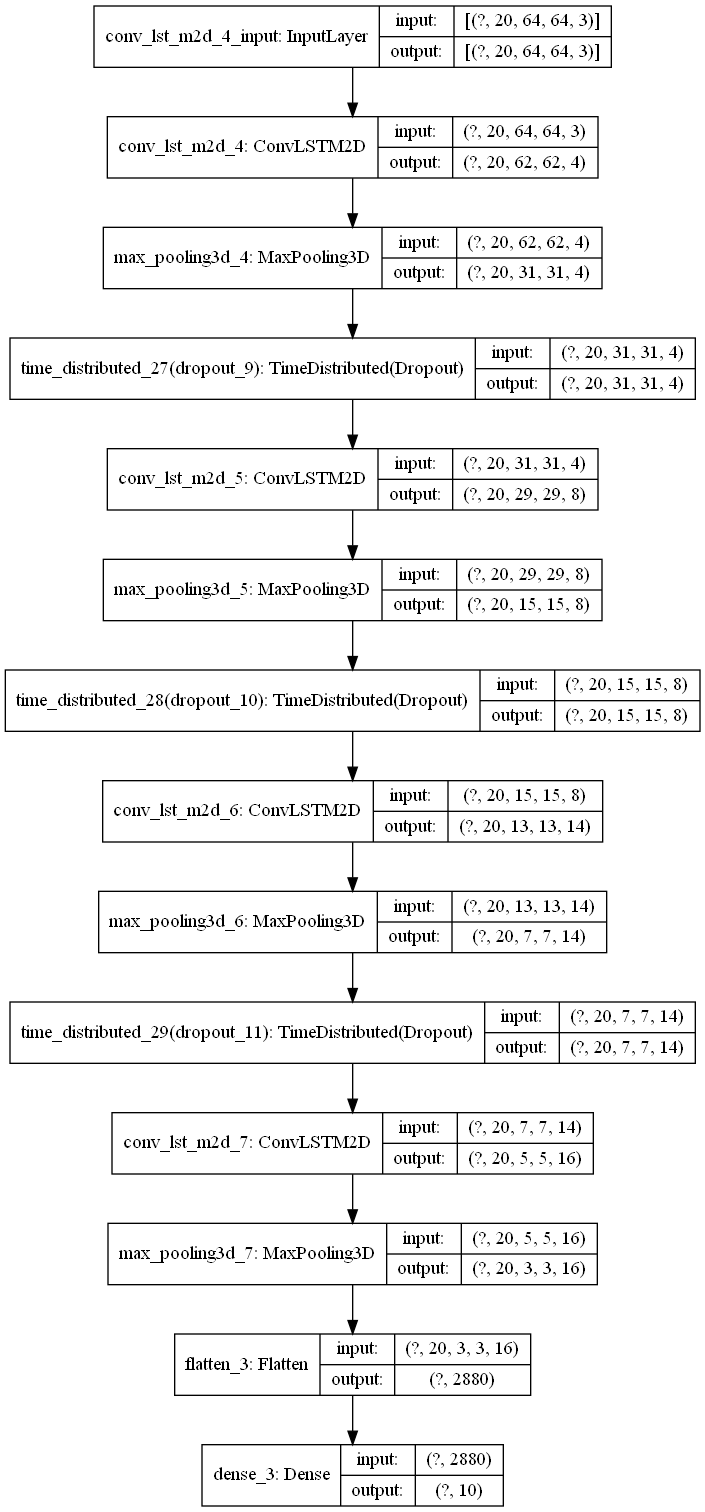

In [58]:
plot_model(convlstm_model, to_file = 'convlstm_model_structure_plot.png', show_shapes = True, show_layer_names = True)

In [59]:

early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'min', restore_best_weights = True)


convlstm_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

convlstm_model_training_history = convlstm_model.fit(x = features_train, y = labels_train, epochs = 50, batch_size = 4,
                                                     shuffle = True, validation_split = 0.2, 
                                                     callbacks = [early_stopping_callback])

Epoch 1/50
202/202 [==============================] - 276s 1s/step - loss: 2.1233 - accuracy: 0.2252 - val_loss: 1.8987 - val_accuracy: 0.3054
Epoch 2/50
202/202 [==============================] - 269s 1s/step - loss: 1.7348 - accuracy: 0.3713 - val_loss: 1.7098 - val_accuracy: 0.4039
Epoch 3/50
202/202 [==============================] - 269s 1s/step - loss: 1.4119 - accuracy: 0.5334 - val_loss: 1.2510 - val_accuracy: 0.5714
Epoch 4/50
202/202 [==============================] - 271s 1s/step - loss: 1.1541 - accuracy: 0.6126 - val_loss: 1.0699 - val_accuracy: 0.6207
Epoch 5/50
202/202 [==============================] - 275s 1s/step - loss: 0.8916 - accuracy: 0.7079 - val_loss: 1.0991 - val_accuracy: 0.6108
Epoch 6/50
202/202 [==============================] - 2063s 10s/step - loss: 0.6643 - accuracy: 0.7735 - val_loss: 0.9508 - val_accuracy: 0.6847
Epoch 7/50
202/202 [==============================] - 228s 1s/step - loss: 0.5461 - accuracy: 0.8181 - val_loss: 1.0034 - val_accuracy: 0.67

In [60]:
model_evaluation_history = convlstm_model.evaluate(features_test, labels_test)

11/11 [==============================] - 14s 1s/step - loss: 1.0609 - accuracy: 0.6855


In [ ]:
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history


date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)


model_file_name = f'convlstm_model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'

convlstm_model.save(model_file_name)

In [22]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    
    
    
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]
    
    epochs = range(len(metric_value_1))

    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

    plt.title(str(plot_name))

    plt.legend()

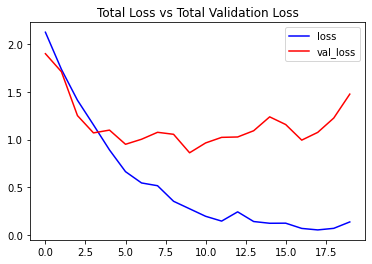

In [68]:
plot_metric(convlstm_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

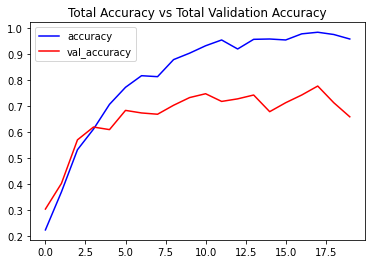

In [69]:
plot_metric(convlstm_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy') 

In [23]:
def create_LRCN_model():
    '''
    This function will construct the required LRCN model.
    Returns:
        model: It is the required constructed LRCN model.
    '''

    # We will use a Sequential model for model construction.
    model = Sequential()
    
    
    
    model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same',activation = 'relu'),
                              input_shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    
    model.add(TimeDistributed(MaxPooling2D((4, 4)))) 
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    
                                      
    model.add(TimeDistributed(Flatten()))
                                      
    model.add(LSTM(32))
                                      
    model.add(Dense(len(CLASSES_LIST), activation = 'softmax'))

    ########################################################################################################################

    
    model.summary()
    
    return model

In [24]:

LRCN_model = create_LRCN_model()


print("Model Created Successfully!")

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_12 (TimeDis (None, 20, 64, 64, 16)    448       
_________________________________________________________________
time_distributed_13 (TimeDis (None, 20, 16, 16, 16)    0         
_________________________________________________________________
time_distributed_14 (TimeDis (None, 20, 16, 16, 16)    0         
_________________________________________________________________
time_distributed_15 (TimeDis (None, 20, 16, 16, 32)    4640      
_________________________________________________________________
time_distributed_16 (TimeDis (None, 20, 4, 4, 32)      0         
_________________________________________________________________
time_distributed_17 (TimeDis (None, 20, 4, 4, 32)      0         
_________________________________________________________________
time_distributed_18 (TimeDis (None, 20, 4, 4, 64)     

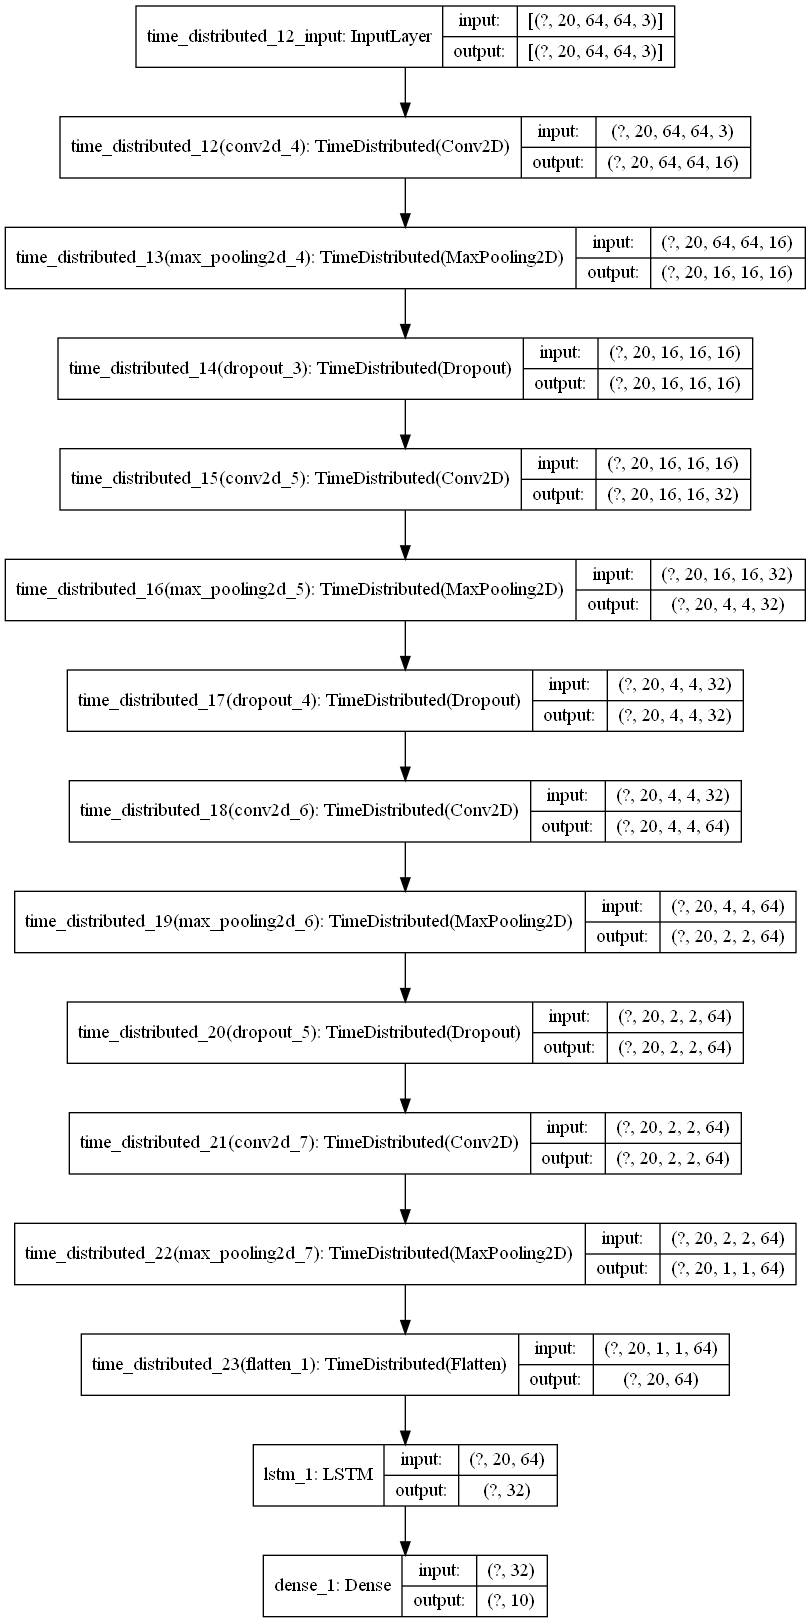

In [25]:
plot_model(LRCN_model, to_file = 'LRCN_model_structure_plot.png', show_shapes = True, show_layer_names = True)

In [26]:

early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)
 
LRCN_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

LRCN_model_training_history = LRCN_model.fit(x = features_train, y = labels_train, epochs = 70, batch_size = 4 ,
                                             shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])

Epoch 1/70
202/202 [==============================] - 34s 166ms/step - loss: 2.2768 - accuracy: 0.1349 - val_loss: 2.1802 - val_accuracy: 0.2414
Epoch 2/70
202/202 [==============================] - 21s 103ms/step - loss: 1.9828 - accuracy: 0.2649 - val_loss: 1.9013 - val_accuracy: 0.3005
Epoch 3/70
202/202 [==============================] - 20s 98ms/step - loss: 1.8192 - accuracy: 0.3577 - val_loss: 1.8545 - val_accuracy: 0.3251
Epoch 4/70
202/202 [==============================] - 20s 97ms/step - loss: 1.6327 - accuracy: 0.4295 - val_loss: 1.7222 - val_accuracy: 0.4286
Epoch 5/70
202/202 [==============================] - 20s 99ms/step - loss: 1.4192 - accuracy: 0.5050 - val_loss: 1.6016 - val_accuracy: 0.3793
Epoch 6/70
202/202 [==============================] - 19s 94ms/step - loss: 1.3268 - accuracy: 0.5495 - val_loss: 1.4748 - val_accuracy: 0.5074
Epoch 7/70
202/202 [==============================] - 19s 94ms/step - loss: 1.2149 - accuracy: 0.5978 - val_loss: 1.4564 - val_accurac

In [27]:
model_evaluation_history = LRCN_model.evaluate(features_test, labels_test)

11/11 [==============================] - 2s 208ms/step - loss: 0.4904 - accuracy: 0.8843


In [32]:
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history


date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)
    
model_file_name = f'LRCN_model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'

LRCN_model.save(model_file_name)

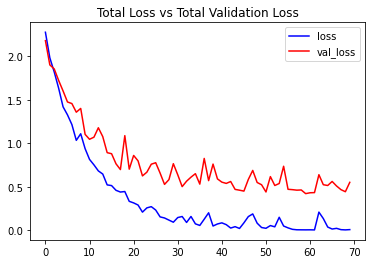

In [33]:
plot_metric(LRCN_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

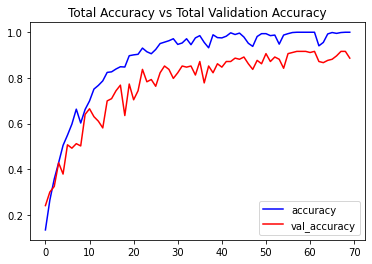

In [34]:
plot_metric(LRCN_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

In [35]:
def download_youtube_videos(youtube_video_url, output_directory):
     
     video = pafy.new(youtube_video_url)
 
     title = video.title
 
     video_best = video.getbest()
 
     output_file_path = f'{output_directory}/{title}.mp4'
 
     video_best.download(filepath = output_file_path, quiet = True)
 
     # Return the video title.
     return title

In [52]:
test_videos_directory = 'test_videos'
os.makedirs(test_videos_directory, exist_ok = True)

video_title = download_youtube_videos('https://youtu.be/ZUIH9L21Kns', test_videos_directory)

input_video_file_path = f'{test_videos_directory}/{video_title}.mp4'

In [53]:
model_json=LRCN_model.to_json()
with open("model.json","w") as file:
    file.write(model_json)
LRCN_model.save_weights("weights.h5")
from tensorflow.keras.models import model_from_json
with open("model.json","r") as file:
    model_json=file.read()
loaded_model=model_from_json(model_json)
loaded_model.load_weights("weights.h5")

In [54]:
def predict_on_video(video_file_path, output_file_path, SEQUENCE_LENGTH):
    

    video_reader = cv2.VideoCapture(video_file_path)

    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

    video_writer = cv2.VideoWriter(output_file_path, cv2.VideoWriter_fourcc('M', 'P', '4', 'V'), 
                                   video_reader.get(cv2.CAP_PROP_FPS), (original_video_width, original_video_height))

    frames_queue = deque(maxlen = SEQUENCE_LENGTH)

    predicted_class_name = ''

    while video_reader.isOpened():

        ok, frame = video_reader.read() 
        
        if not ok:
            break

        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        
        normalized_frame = resized_frame / 255

        frames_queue.append(normalized_frame)

        if len(frames_queue) == SEQUENCE_LENGTH:

            predicted_labels_probabilities = loaded_model.predict(np.expand_dims(frames_queue, axis = 0))[0]

            predicted_label = np.argmax(predicted_labels_probabilities)

            predicted_class_name = CLASSES_LIST[predicted_label]

        cv2.putText(frame, predicted_class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

        video_writer.write(frame)
        
    video_reader.release()
    video_writer.release()

In [55]:
output_video_file_path = f'{test_videos_directory}/{video_title}-Output-SeqLen{SEQUENCE_LENGTH}.mp4'

predict_on_video(input_video_file_path, output_video_file_path, SEQUENCE_LENGTH)

VideoFileClip(output_video_file_path, audio=False, target_resolution=(300,None)).ipython_display()

t:  27%|██████████████████                                                 | 39/145 [00:00<00:00, 387.84it/s, now=None]

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


In [62]:
def predict_single_action(video_file_path, SEQUENCE_LENGTH):
    

    video_reader = cv2.VideoCapture(video_file_path)

    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

    frames_list = []
    
    predicted_class_name = ''

    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH),1)

    for frame_counter in range(SEQUENCE_LENGTH):

        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        success, frame = video_reader.read() 

        if not success:
            break

        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        
        normalized_frame = resized_frame / 255
        
        frames_list.append(normalized_frame)

    predicted_labels_probabilities = LRCN_model.predict(np.expand_dims(frames_list, axis = 0))[0]

    predicted_label = np.argmax(predicted_labels_probabilities)

    predicted_class_name = CLASSES_LIST[predicted_label]
    
    print(f'Action Predicted: {predicted_class_name}\nConfidence: {predicted_labels_probabilities[predicted_label]}')
        
    video_reader.release()

In [67]:
video_title = download_youtube_videos('https://youtu.be/_0_sS983KhY', test_videos_directory)

input_video_file_path = f'{test_videos_directory}/{video_title}.mp4'

predict_single_action(input_video_file_path, SEQUENCE_LENGTH)



Action Predicted: Biking
Confidence: 0.9991831183433533
